<a href="https://colab.research.google.com/github/AmitNativ1984/Autobrains-Unet-Cityscapes/blob/main/Algo_DNN_Home_Assignment_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TASK 1 - Semantic Segmentation using U-net

Identifying the drivable area provides critical information for navigating and path planning in autonomous driving. In this task you will take the first step torward this feature by segmenting the road in the image.


# **Save Your Time**
Please first download the data. The data is transfered via Google drive which somtimes slow.
*   [Zip file - containing the data](https://drive.google.com/file/d/1_Demk2hTXuVPq9bBToedS4fOLqwaG7N3/view?usp=share_link)
*   [Google drive with all the files](https://drive.google.com/drive/folders/10udfdPAT0yPq1TA7Ld0ddSKMedbEJBoe?usp=share_link)

![](https://raw.githubusercontent.com/henyau/Image-Segmentation-with-Unet/master/images/train_label.png)


You are provided with a partial training code of a U-net model. Your task is to train a model that predicts the road segment in the image. Please implement the missing components of the training pipeline, train the model and preform evaluation.

### Data - road and vehicle segmentation

The zip file provided contains images and high quality dense pixel annotations (fine annotation). The data is split into train (\~2900 images) and validation (\~500 images) with the directories similar the original Cityscapes dataset. 

The original Cityscapes anotations contains 19 classes. Please reduce the number of classes from 19 to the following 3: “background”, “vehicle”, “road”.You can read more about Cityscape here https://www.cityscapes-dataset.com/dataset-overview/#labeling-policy.


The Zip file provides with the following:
1.   cityscapes dir - a directory with the images and annotations. Make sure the annotations contains the 3 classes mentioned above
2.   image_list dir - a tsv file for train and validation. Each row in the tsv is a pairs of paths, path to image and path to annotation. In each TSV change **/PATH_TO_CITYSCAPES_DATA_DIR/** to the absolute path of cityscapes dir



To save time:
*   Resize images to a small fixed-size that will enable you to train the model in a fesiable time.

# **Deliverables**


1.   Complete the training code for road segmentation (marked "COMPLETE ME"):
  * **Loss function** (Training Flow section)
  * **Optimizer** (Training Flow section)
  * **Augmentations** (Data preparations section)
2.   **Perform an evaluation of your trained model** (Evaluation section)


# **Thoughts and Notes**
---
1. Train simply and look at results for the first time
2. Is the initial model trained? is it possible to do transfer learning / fine tuning?
3. **USE TENSORBOARD**: Monitor the following:

  3.1. Total Train loss

  3.2.  Train loss per class
  
  3.3.  Validation loss

  3.4.  Validation loss per class

  3.5.  Validation images

*   weight differently unimportant classes
*   focal loss
*   crop original size into diffferent scales
* Penalize the road more!

## Questions:
* Should evel part be provided?

## Augmentations:
1. normalized cityscapes RGB values
2. resolusion / scale - keep aspect ratio
3. albumentations: weather condition
4. flips (left/right)
5. blurs - gaussian/motion

6. Pay attension to augmentations for valdiation and test.
7. Pay attension to downsampling and required augmenations for masks!


### Trainer Class

In [16]:
import numpy as np
import torch
from PIL import Image
import os

from torch.utils.tensorboard import SummaryWriter

In [17]:
class Trainer:
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset = None,
                 lr_scheduler: torch.optim.lr_scheduler = None,
                 epochs: int = 100,
                 epoch: int = 0,
                 notebook: bool = False
                 ):

        self.model = model
        self.criterion = criterion.cuda()
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs
        self.epoch = epoch
        self.notebook = notebook

        self.training_loss = []
        self.validation_loss = []
        self.learning_rate = []

        self.tb_writer = SummaryWriter()

    def run_trainer(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        progressbar = trange(self.epochs, desc='Progress')
        for i in progressbar:
            """Epoch counter"""
            self.epoch += 1  # epoch counter

            """Training block"""
            self._train()

            """Validation block"""
            if self.validation_DataLoader is not None:
                self._validate()

            """Learning rate scheduler block"""
            if self.lr_scheduler is not None:
                if self.validation_DataLoader is not None and self.lr_scheduler.__class__.__name__ == 'ReduceLROnPlateau':
                    self.lr_scheduler.step(
                        self.validation_loss[i])  # learning rate scheduler step with validation loss
                else:
                    self.lr_scheduler.step()  # learning rate scheduler step
        return self.training_loss, self.validation_loss, self.learning_rate

    def _train(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        self.model.train()  # train mode
        train_losses = []  # accumulate the losses here
        batch_iter = tqdm(enumerate(self.training_DataLoader), 'Training', total=len(self.training_DataLoader),
                          leave=False)
        for i, (x, y) in batch_iter:
            input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)
            self.optimizer.zero_grad()  # zerograd the parameters
            out = self.model(input)  # one forward pass
            loss = self.criterion(out, target.long())  # calculate loss
            loss_value = loss.item()
            train_losses.append(loss_value)
            loss.backward()  # one backward pass
            self.optimizer.step()  # update the parameters

            batch_iter.set_description(f'Training: (loss {loss_value:.4f})')  # update progressbar

        print("MEAN LOSS: {}".format(np.mean(train_losses)))
        self.training_loss.append(np.mean(train_losses))
        self.learning_rate.append(self.optimizer.param_groups[0]['lr'])

        self.tb_writer.add_scalar('Loss/train', np.mean(train_losses), self.epoch)
        self.tb_writer.add_scalar('Learning rate', self.optimizer.param_groups[0]['lr'], self.epoch)
        
        batch_iter.close()

    def _validate(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        self.model.eval()  # evaluation mode
        valid_losses = []  # accumulate the losses here
        batch_iter = tqdm(enumerate(self.validation_DataLoader), 'Validation', total=len(self.validation_DataLoader),
                          leave=False)

        for i, (x, y) in batch_iter:
            input, target = x.to(self.device), y.to(self.device)  # send to device (GPU or CPU)

            with torch.no_grad():
                out = self.model(input)
                loss = self.criterion(out, target.long())
                loss_value = loss.item()
                valid_losses.append(loss_value)

                batch_iter.set_description(f'Validation: (loss {loss_value:.4f})')

        self.validation_loss.append(np.mean(valid_losses))
        print("VAL MEAN LOSS: {}".format(np.mean(valid_losses)))

        self.tb_writer.add_scalar('Loss/val', np.mean(valid_losses), self.epoch)

        batch_iter.close()

###  Data preparations

#### Augmentations

In [18]:
import os
import cv2
import torch
import random
import numbers
import numpy as np
from PIL import Image, ImageOps, ImageFilter
from torchvision import transforms

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample: tuple) -> tuple:
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        img, mask = sample
        img = np.array(img).astype(np.float32).transpose((2, 0, 1))
        mask = np.array(mask).astype(np.float32)

        img, mask = self.resize(img, mask, (128, 128))
        
        img = torch.from_numpy(img).float()
        mask = torch.from_numpy(mask).float()

        img = self.normalize(img)
        
        return img, mask

# Add your augmentations here
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
# ----------------------------"COMPLETE ME"------------------------------------
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------

    def normalize(self, img: torch.Tensor) -> torch.Tensor:
        # Normalize the image
        normalize = [
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ]
        
        img = transforms.Compose(normalize)(img)
        return img

    def resize(self, img, mask, size: tuple):
        
        # Resize
        resize_img = transforms.Resize(size, interpolation=transforms.InterpolationMode.BICUBIC)
        resize_mask = transforms.Resize(size, interpolation=transforms.InterpolationMode.NEAREST)
        img = resize_img(img)
        mask = resize_mask(mask)
        
        # Resize the image
        img = transforms.Compose([resize_img])(img)
        mask = transforms.Compose([resize_mask])(mask)
        return img, mask

#### Dataset object

In [19]:
from torch.utils import data
from torchvision import transforms

class TrainDataset(data.Dataset):
    """
    Dataset for semantic segmentation. Data is stored as image list. 
    An image list file is a tsv file where each row contains the path to an image and its gt path.
    """
    NUM_CLASSES = 19

    def __init__(self, img_list_path: str, split="train"):
        """
        :param args: dataset args for training
        :param img_list_path: path to the directory of image list files
        :param split: type of dataset, train test or validation
        """
        self.split = split
        self.files = {}
        self.gts = {}
        imgs = []
        gts = []

        # Parsing the image_list  
        for dirpath, dirnames, filenames in os.walk(os.path.join(img_list_path, split)):
            for file in filenames:
                with open(os.path.join(dirpath, file), mode='r') as img_list:
                    for row in img_list:
                        _, img, gt = row.split('\t')
                        imgs.append(img)
                        gts.append(gt.strip())

        self.files[split] = imgs
        self.gts[split] = gts

        # Cityscapes classes 
        self.void_classes = [0, 1, 2, 3, 4, 5, 6, 9, 10, 14, 15, 16, 18, 29, 30, -1]
        self.valid_classes = [7, 8, 11, 12, 13, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33]
        self.class_names = ['unlabelled', 'road', 'sidewalk', 'building', 'wall', 'fence', \
                            'pole', 'traffic_light', 'traffic_sign', 'vegetation', 'terrain', \
                            'sky', 'person', 'rider', 'car', 'truck', 'bus', 'train', \
                            'motorcycle', 'bicycle']

        self.ignore_index = 255
        
        self.class_map = self.reduce_class_map()      
        
        self.set_augmentation_type()

        if not self.files[split]:
            raise Exception("No files for split=[%s] found in %s" % (split, img_list_path))

        print("Found %d %s images" % (len(self.files[split]), split))

    def __len__(self):
        return len(self.files[self.split])

    def __getitem__(self, index):
        img_path = self.files[self.split][index].rstrip()
        lbl_path = self.gts[self.split][index].rstrip()

        _img = np.array(Image.open(img_path).convert('RGB'))
        _target = np.array(Image.open(lbl_path), dtype=np.uint8)

        # # Encoding mask to contain only valid classes:
        # self.encode_segmap(_target)
        
        _img = Image.fromarray(_img)
        _target = Image.fromarray(_target)

        sample = (_img, _target)
        if self.split == 'train':
            return self.transform_train(sample)
        elif self.split == 'val':
            return self.transform_validation(sample)
        elif self.split == 'test':
            return self.transform_test(sample)

    def encode_segmap(self, mask):
        # Put all void classes to zero
        for _voidc in self.void_classes:
            mask[mask == _voidc] = self.ignore_index
        for _validc in self.valid_classes:
            mask[mask == _validc] = self.class_map[_validc]
        return mask

    def set_seed(self, seed):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
       
    
    def transform_tr(self, sample):                       
        transforms.RandomApply(torch.nn.ModuleList([
                                        transforms.RandomCrop((256, 256)),
                                        ]), 
                                    p=0.3)
        
        geometric_transforms = [
            # transforms.RandomCrop((256, 256)),
            transforms.RandomHorizontalFlip(p=0.5),
        ]

        color_transforms = [
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2)
        ]
        
        state = torch.get_rng_state()
        img = sample[0]
        img_transforms = transforms.Compose(geometric_transforms + color_transforms)
        img_aug = img_transforms(img)

        torch.set_rng_state(state)
        mask = sample[1]
        mask_transforms = transforms.Compose(geometric_transforms)
        mask_aug = mask_transforms(mask)
        
        sample = (img, mask_aug)

        composed_transforms = transforms.Compose([ToTensor()])
        return composed_transforms(sample)

    def transform_val(self, sample):
        
        composed_transforms = transforms.Compose([ToTensor()])
        return composed_transforms(sample)

    def transform_ts(self, sample):

        composed_transforms = transforms.Compose([ToTensor()])
        return composed_transforms(sample)

    def get_img_list(self):
        img_list = [(img_path, os.path.join(self.annotations_base,
                                            img_path.split(os.sep)[-2],
                                            os.path.basename(img_path)[:-15] + 'gtFine_labelIds.png')) for img_path in
                    self.files[self.split]]
        return img_list

    def set_augmentation_type(self):
        self.transform_train = self.transform_tr
        self.transform_validation = self.transform_val
        self.transform_test = self.transform_ts


    def reduce_class_map(self):
    # Reduce the number of classes from 19 to the following 3: “background”, “vehicle”, “road”:
    # The guidelines: 
    #   1. Everything that can be found on the road wil be marked as vehicle:
    #       a. All vechile types.
    #       b. Person and rider classes as well, as they can be found on the road, and should not be labeled as "Road"

    # valid class id  | class name      | new class name    | new class id | 
    #     0           | unlabeled       |  unlabeld         |  0
    #     7           | road            |  road             |  1
    #     8           | sidewalk        |  background       |  2
    #     11          | building        |  background       |  2
    #     12          | wall            |  background       |  2
    #     13          | fence           |  background       |  2
    #     17          | pole            |  background       |  2
    #     19          | traffic light   | background        |  2
    #     20          | traffic sign    | background        |  2
    #     21          | vegetation      | background        |  2
    #     22          | terrain         |  background       |  2
    #     23          | sky             |  background       |  2
    #     24          | person          |  vehicle          |  3
    #     25          | rider           |  vehicle          |  3
    #     26          | car             |  vehicle          |  3
    #     27          | truck           |  vehicle          |  3
    #     28          | bus             |  vehicle          |  3
    #     31          | train           |  vehicle          |  3
    #     32          | motorcycle      |  vehicle          |  3
    #     33          | bicycle         |  vehicle          |  3
    
        class_map = {0: 0, #unlabeled -> unlabeled
                    7: 1, #road -> road
                    8: 2, #sidewalk -> background
                    11: 2, #building -> background
                    12: 2, #wall -> background
                    13: 2, #fence -> background
                    17: 2, #pole -> background
                    19: 2, #traffic light -> background
                    20: 2, #traffic sign -> background
                    21: 2, #vegetation -> background
                    22: 2, #terrain -> background
                    23: 2, #sky -> background
                    24: 3, #person -> vehicle25
                    25: 3, #rider -> vehicle
                    26: 3, #car -> vehicle
                    27: 3, #truck -> vehicle
                    28: 3, #bus -> vehicle
                    31: 3, #train -> vehicle
                    32: 3, #motorcycle -> vehicle
                    33: 3 #bicycle -> vehicle
                    }
        return class_map

### Training Flow

In [20]:
!pip install unet

In [21]:
import pathlib
import torch

import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from skimage.transform import resize
from unet import UNet

In [22]:
img_list_dir = "/DATA/img_list"
# For example: img_list_dir = "/content/drive/MyDrive/Algo_Home_Assignment/Cityscapes/img_list"
batch_size = 8

In [23]:
train_set = TrainDataset(img_list_path=img_list_dir, split='train')
val_set = TrainDataset(img_list_path=img_list_dir, split='val')
dataloader_training = DataLoader(train_set, batch_size=batch_size, drop_last=True, shuffle=True)
dataloader_validation = DataLoader(val_set, batch_size=1, drop_last=True, shuffle=False)

Found 2975 train images
Found 500 val images


In [24]:
class Config():
  def __init__(self) -> None:
      self.EPOCHS = 10
      # lr
      self.lr = 0.001
      self.momentum = 0.9
      
      # lr scheduler
      self.multistep_milestones = [5, 8]
      self.lr_gamma = 0.1

In [25]:
# from ipywidgets import IntProgress

GPU


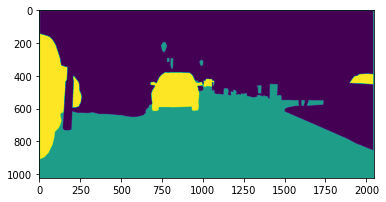

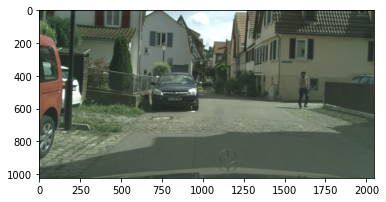

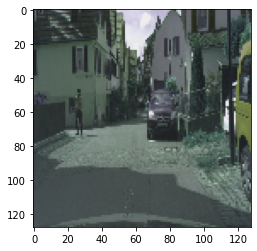

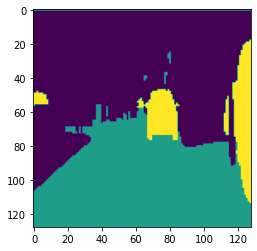

MEAN LOSS: 0.9710780349221191


VAL MEAN LOSS: 0.6014378163814544


MEAN LOSS: 0.5823685142871826


VAL MEAN LOSS: 0.62847401958704


MEAN LOSS: 0.5319709854948553


VAL MEAN LOSS: 0.5173218433856964


MEAN LOSS: 0.49941703323726705


VAL MEAN LOSS: 0.48888002017140386


KeyboardInterrupt: 

In [26]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU")
else:
    print("CPU")
    torch.device('cpu')

# model
model = UNet(in_channels=3,
             out_classes=19,
             out_channels_first_layer=64,
             num_encoding_blocks=2,
             padding=2,
             dimensions=2).to(device)

# -----------------------------------------------------------------------------
# ---------------------------------  "COMPLETE ME"  ---------------------------
config = Config()

# Add a loss function 
criterion = torch.nn.CrossEntropyLoss(ignore_index=255)


## Add an optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=config.lr, momentum=config.momentum)


## Add a learning rate scheduler 
lr_scheduler=torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=config.multistep_milestones, gamma=config.lr_gamma)

# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------
# -----------------------------------------------------------------------------


# trainer
trainer = Trainer(model=model,
                  device=device,
                  criterion=criterion,
                  optimizer=optimizer,
                  training_DataLoader=dataloader_training,
                  validation_DataLoader=dataloader_validation,
                  lr_scheduler=lr_scheduler,
                  epochs=config.EPOCHS,
                  epoch=0,
                  notebook=True)

# start training
training_losses, validation_losses, lr_rates = trainer.run_trainer()


GOOD LUCK !